# Subset data for faster training, splitting train/val/test datasets

In [8]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pybedtools
from tqdm import tqdm 
import numpy as np 
import anndata
import scanpy as sc 
from helpers import * 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
BASE_DIR = "/ssd/users/cfx"
chip_data_dir = f"{BASE_DIR}/data/ENCODE_ChIP"
rna_data_dir = f"{BASE_DIR}/data/ENCODE_Bulk_RNA"
Target_dir = f"./data"

In [24]:
ad_rna_bulk = sc.read_h5ad(f"{Target_dir}/ad_rna_bulk.h5ad")
ad_chip = sc.read_h5ad(f"{Target_dir}/ad_chip_filtered.h5ad")
ad_chip

AnnData object with n_obs × n_vars = 1701 × 1086397
    obs: 'Accession', 'Target of assay', 'Biosample term name', 'Biosample classification', 'Assay title', 'bed narrowPeak', 'process version'
    var: 'chr', 'start', 'end'

In [25]:
tf_annotate = read_JASPAR_pwms(meme_file=f"{BASE_DIR}/genomes/JASPAR_human_TFs_meme/20250327110737_JASPAR2024_combined_matrices_532533_meme.txt")
tf_annotate[:5]

,motif,tf,pwm
0,MA0634.2,ALX3,"[[0.088066, 0.373447, 0.038265, 0.500222], [0...."
1,MA0007.2,AR,"[[0.560146, 0.099233, 0.272086, 0.068535], [0...."
2,MA1463.2,ARGFX,"[[0.101035, 0.655226, 0.069042, 0.174698], [0...."
3,MA1464.2,ARNT2,"[[0.251527, 0.091059, 0.615761, 0.041654], [0...."
4,MA0259.2,ARNT::HIF1A,"[[0.75, 0.019231, 0.221154, 0.009615], [0.0, 0..."


In [18]:
### number of positive peaks for each chromosome
ad_chip.var['chr'].value_counts()

chr
chr2     96312
chr1     94812
chr3     75530
chr6     68597
chr5     65488
chr7     62639
chr4     61804
chr8     54366
chr12    52234
chr10    51595
chr11    49337
chr9     42086
chr17    36598
chr14    34949
chr16    33018
chr15    33004
chr13    32895
chrX     32818
chr20    29221
chr18    26323
chr19    24007
chr22    14793
chr21    12910
chrY      1061
Name: count, dtype: int64

In [26]:
chr_subset = ['chr19', 'chr20', 'chr21', 'chr22']
tf_subset = tf_annotate['tf'].to_list()
print(ad_chip.shape, len(ad_chip.obs['Biosample term name'].unique()))
ad_chip = ad_chip[:, ad_chip.var['chr'].isin(chr_subset)]
ad_chip = ad_chip[ad_chip.obs['Target of assay'].isin(tf_subset), :]
ad_chip = ad_chip[:,ad_chip.X.sum(axis=0).flatten()>0]
ad_chip = ad_chip[ad_chip.X.sum(axis=1).flatten()>0,:]
print(ad_chip.shape, len(ad_chip.obs['Biosample term name'].unique()))


(1701, 1086397) 28
(962, 67374) 19


In [152]:
ad_chip.write_h5ad(f"{Target_dir}/ad_chip_chromsubset.h5ad")

## TF-celltype information

In [20]:
ad_chip = sc.read_h5ad(f"{Target_dir}/ad_chip_chromsubset.h5ad")

In [21]:
heatmap_data = ad_chip.obs.groupby(['Target of assay', 'Biosample term name']).size().unstack(fill_value=0).T
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]
heatmap_data = heatmap_data[heatmap_data.sum(axis=0).sort_values(ascending=False).index]
heatmap_data

/tmp/ipykernel_2826215/148506653.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = ad_chip.obs.groupby(['Target of assay', 'Biosample term name']).size().unstack(fill_value=0).T


Target of assay,REST,MAX,JUND,CEBPB,MYC,ZBTB33,SP1,ELF1,ATF3,JUN,...,E2F2,CTCFL,E2F3,ARNT2,ZNF770,ZNF784,ZNF816,ZSCAN21,AR,ZSCAN31
Biosample term name,,,,,,,,,,,,,,,,,,,,,
K562,4,4,2,3,4,3,3,4,5,3,...,0,1,1,0,0,0,0,0,0,0
HepG2,2,3,3,2,2,3,3,2,2,2,...,1,0,0,1,1,1,1,1,0,1
GM12878,2,1,2,2,1,2,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0
MCF-7,1,1,1,1,3,1,1,3,0,1,...,0,0,0,0,0,0,0,0,0,0
WTC11,0,1,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
A549,1,2,0,3,1,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
H1,2,2,2,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
HeLa-S3,1,2,1,1,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SK-N-SH,2,1,2,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


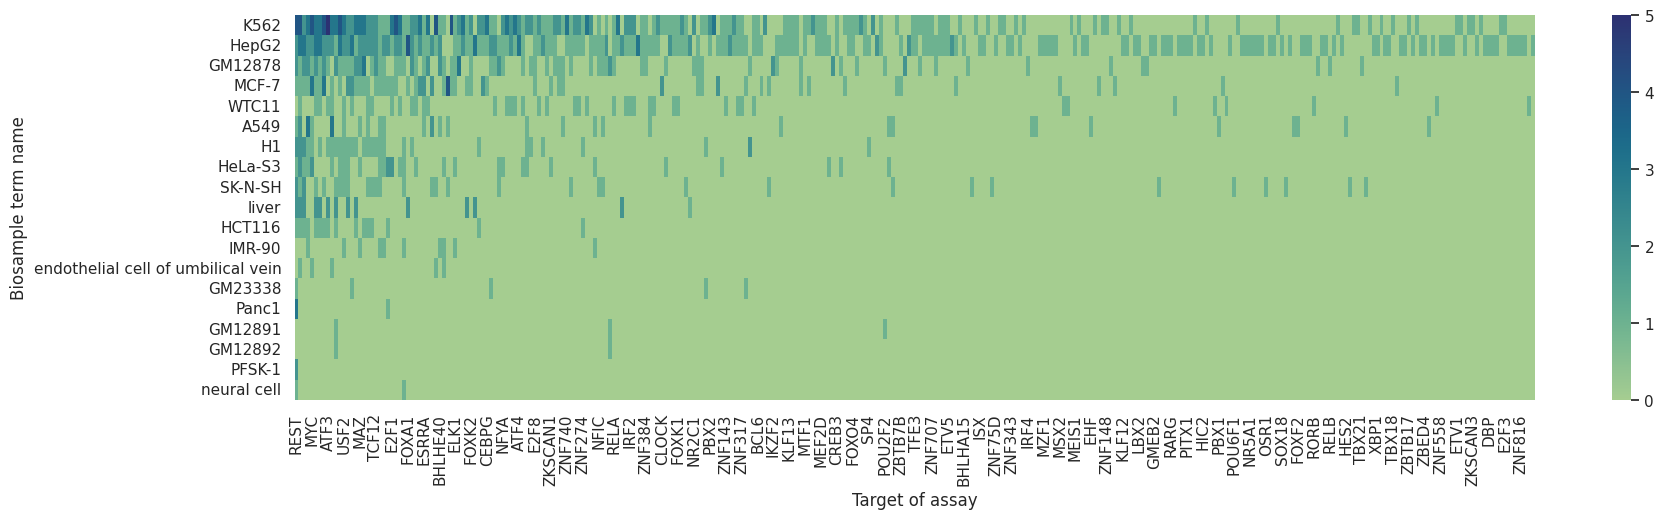

In [11]:
fig = plt.figure(figsize=(20,5))
sns.set(font_scale=1) 
sns.heatmap(heatmap_data, cmap="crest", 
            # xticklabels=True, 
            yticklabels=True
            )
fig.savefig("./data/figs/ct_tf_counts.svg", dpi=300, bbox_inches='tight')

In [ ]:
# heatmap_data.to_csv(f"{Target_dir}/meta_data/TF_CT_count.csv")

## dataloader test 

In [3]:
from helpers import * 

In [19]:
data = DataLoader(
    trial_path="./tasks/taska/trial1",
    rna_path = "./data/ad_rna_bulk.h5ad",
    chip_path = "./data/ad_chip_chromsubset.h5ad",
    tf_path = f"{BASE_DIR}/genomes/JASPAR_human_TFs_meme/20250327110737_JASPAR2024_combined_matrices_532533_meme.txt",
    rna_func=None,
    tf_func = None,
    fasta_ref = f"{BASE_DIR}/genomes/hg38/hg38.fa",
    )

ds = data.read_ds(key="train")
print(ds['Y_chip'].shape,       # (n_sample, n_region)
      len(ds['X_seq']),         # (n_region,)
      ds['X_rna'].shape,        # (n_sample, n_feature)
      len(ds['X_tf']))          # (n_sample)

subset chip to ['A549', 'H1', 'Panc1', 'endothelial cell of umbilical vein', 'liver', 'MCF-7', 'neural cell', 'WTC11', 'HeLa-S3', 'GM12891', 'IMR-90', 'GM12878', 'SK-N-SH', 'GM12892', 'HCT116', 'GM23338', 'PFSK-1', 'K562', 'HepG2'], ['REST']
chip shape : (25, 9528)
write chip region fastas to ./tasks/taska/trial1/chip_seqs.fasta


/ssd/users/cfx/DNA-AI-hackathon/task2_Seq2CellxTF/helpers.py:184: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.chip.obs["_cttf"] = k_all
/ssd/users/cfx/DNA-AI-hackathon/task2_Seq2CellxTF/helpers.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['feature'] = df_out['pwm']
reading fasta: 100%|██████████| 6415/6415 [00:00<00:00, 11152.90it/s]

(11, 6415) 6415 (11, 20) 11


In [20]:
data = DataLoader(trial_path="./tasks/taskb/trial1")
ds = data.read_ds(key="train")
print(ds['Y_chip'].shape, len(ds['X_seq']), ds['X_rna'].shape, len(ds['X_tf']))

subset chip to ['K562'], ['ZNF331', 'TCF7', 'KLF16', 'ELK3', 'OTX1', 'ZNF707', 'PRDM4', 'RORA', 'ONECUT2', 'ONECUT1', 'E2F8', 'GFI1', 'ELF2', 'HSF2', 'NFYA', 'RELB', 'BCL6', 'BACH1', 'TEAD4', 'TCF4', 'ZSCAN21', 'TCF7L2', 'NR2F1', 'FOXS1', 'SIX1', 'TCF12', 'RUNX1', 'ATF4', 'POU5F1', 'FOXP4', 'ZNF574', 'DBP', 'ZNF384', 'ZNF257', 'ZBTB14', 'SOX18', 'REST', 'E2F4', 'MEIS1', 'KLF15', 'NKX3-1', 'ZNF140', 'BHLHA15', 'FOSL2', 'SP1', 'ZNF263', 'KLF5', 'NR2C1', 'POU2F1', 'TFDP1', 'GLIS3', 'TFAP2B', 'ZNF416', 'PBX1', 'TFAP4', 'IRF3', 'PAX5', 'ESRRA', 'SOX13', 'ZBTB24', 'FOSL1', 'STAT1', 'NR4A1', 'MNT', 'ZNF75D', 'E2F3', 'THRB', 'MLX', 'ZBTB26', 'CTCFL', 'PBX3', 'ISX', 'CLOCK', 'RELA', 'KLF9', 'NFIX', 'CREB3L1', 'ZBTB17', 'MYC', 'ATF3', 'JUND', 'SMAD3', 'NFATC3', 'ESR1', 'KLF13', 'KLF11', 'TFE3', 'E2F7', 'HOXB13', 'SRF', 'HEY1', 'ATF2', 'ESRRB', 'ZNF76', 'ZNF75A', 'FOXF2', 'FOXK1', 'HES2', 'ZBTB7B', 'IRF4', 'MITF', 'MNX1', 'SNAI2', 'ZBTB11', 'FOXA2', 'ZKSCAN5', 'ETS2', 'ZNF24', 'NR2F2', 'ZNF740', 

/ssd/users/cfx/DNA-AI-hackathon/task2_Seq2CellxTF/helpers.py:184: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.chip.obs["_cttf"] = k_all
/ssd/users/cfx/DNA-AI-hackathon/task2_Seq2CellxTF/helpers.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['feature'] = df_out['pwm']
reading fasta: 100%|██████████| 22358/22358 [00:08<00:00, 2500.58it/s]

(162, 22358) 22358 (162, 20) 162


In [21]:
data = DataLoader(trial_path="./tasks/taskc/trial1")
ds = data.read_ds(key="train")
print(ds['Y_chip'].shape, len(ds['X_seq']), ds['X_rna'].shape, len(ds['X_tf']))

subset chip to ['A549', 'H1', 'Panc1', 'endothelial cell of umbilical vein', 'liver', 'MCF-7', 'neural cell', 'WTC11', 'HeLa-S3', 'GM12891', 'IMR-90', 'GM12878', 'SK-N-SH', 'GM12892', 'HCT116', 'GM23338', 'PFSK-1', 'K562', 'HepG2'], ['ZNF331', 'TCF7', 'KLF16', 'ELK3', 'OTX1', 'ZNF707', 'PRDM4', 'RORA', 'ONECUT2', 'ONECUT1', 'E2F8', 'GFI1', 'ELF2', 'HSF2', 'NFYA', 'RELB', 'BCL6', 'BACH1', 'TEAD4', 'TCF4', 'ZSCAN21', 'TCF7L2', 'NR2F1', 'FOXS1', 'SIX1', 'TCF12', 'RUNX1', 'ATF4', 'POU5F1', 'FOXP4', 'ZNF574', 'DBP', 'ZNF384', 'ZNF257', 'ZBTB14', 'SOX18', 'REST', 'E2F4', 'MEIS1', 'KLF15', 'NKX3-1', 'ZNF140', 'BHLHA15', 'FOSL2', 'SP1', 'ZNF263', 'KLF5', 'NR2C1', 'POU2F1', 'TFDP1', 'GLIS3', 'TFAP2B', 'ZNF416', 'PBX1', 'TFAP4', 'IRF3', 'PAX5', 'ESRRA', 'SOX13', 'ZBTB24', 'FOSL1', 'STAT1', 'NR4A1', 'MNT', 'ZNF75D', 'E2F3', 'THRB', 'MLX', 'ZBTB26', 'CTCFL', 'PBX3', 'ISX', 'CLOCK', 'RELA', 'KLF9', 'NFIX', 'CREB3L1', 'ZBTB17', 'MYC', 'ATF3', 'JUND', 'SMAD3', 'NFATC3', 'ESR1', 'KLF13', 'KLF11', 'TFE

/ssd/users/cfx/DNA-AI-hackathon/task2_Seq2CellxTF/helpers.py:184: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.chip.obs["_cttf"] = k_all
/ssd/users/cfx/DNA-AI-hackathon/task2_Seq2CellxTF/helpers.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['feature'] = df_out['pwm']
reading fasta: 100%|██████████| 44534/44534 [00:33<00:00, 1347.02it/s]

(727, 44534) 44534 (727, 20) 727
